In [60]:
%pip install pandas torch tqdm matplotlib imblearn

Note: you may need to restart the kernel to use updated packages.


In [61]:
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt


In [62]:
df = pd.read_csv("../test_df_unbalanced_classification.csv")

selected_feature = [
    "differentiate",
    "N Stage Encoded",
    "Estrogen Status Encoded",
    "Progesterone Status Encoded",
    "Marital_Widowed",
]

# X = df.drop(columns=["Survival More Than 6 Years"]).values
X = df[selected_feature].values
y = df["Status_encoded"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [63]:
class SLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SLP, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            probs = torch.softmax(logits, dim=1)
            return torch.argmax(probs, dim=1)

In [64]:
def train(model, train_loader, criterion, optimizer, epochs=50):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0

        for X_batch, y_batch in tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"
        ):
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_acc += (predicted == y_batch).sum().item()

        avg_train_loss = train_loss / len(train_dataset)
        avg_train_acc = train_acc / len(train_dataset)

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)

        model.eval()
        val_acc = 0
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(
                test_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation"
            ):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_acc += (predicted == y_batch).sum().item()

        avg_val_loss = val_loss / len(test_dataset)
        avg_val_acc = val_acc / len(test_dataset)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)

        print(
            f"Epoch {epoch + 1}/{epochs} - "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}"
        )

    return train_losses, train_accuracies, val_losses, val_accuracies

In [65]:
model = SLP(input_dim=X_train_tensor.shape[1], output_dim=2)

criterion = nn.CrossEntropyLoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 100

train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, criterion, optimizer, epochs=epochs
)

Epoch 1/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3537.63it/s]


Epoch 1/100 - Train Loss: 0.0212, Train Acc: 0.5878, Val Loss: 0.0214, Val Acc: 0.6518


Epoch 2/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3015.59it/s]


Epoch 2/100 - Train Loss: 0.0211, Train Acc: 0.6162, Val Loss: 0.0214, Val Acc: 0.6518


Epoch 3/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 2973.10it/s]


Epoch 3/100 - Train Loss: 0.0211, Train Acc: 0.6162, Val Loss: 0.0214, Val Acc: 0.6518


Epoch 4/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4046.12it/s]


Epoch 4/100 - Train Loss: 0.0210, Train Acc: 0.6162, Val Loss: 0.0213, Val Acc: 0.6518


Epoch 5/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3980.36it/s]


Epoch 5/100 - Train Loss: 0.0210, Train Acc: 0.6183, Val Loss: 0.0213, Val Acc: 0.6518


Epoch 6/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4407.52it/s]


Epoch 6/100 - Train Loss: 0.0209, Train Acc: 0.6193, Val Loss: 0.0212, Val Acc: 0.6518


Epoch 7/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3996.00it/s]


Epoch 7/100 - Train Loss: 0.0208, Train Acc: 0.6193, Val Loss: 0.0212, Val Acc: 0.6518


Epoch 8/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4340.81it/s]


Epoch 8/100 - Train Loss: 0.0208, Train Acc: 0.6193, Val Loss: 0.0212, Val Acc: 0.6518


Epoch 9/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4357.72it/s]


Epoch 9/100 - Train Loss: 0.0207, Train Acc: 0.6193, Val Loss: 0.0211, Val Acc: 0.6518


Epoch 10/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4130.28it/s]


Epoch 10/100 - Train Loss: 0.0207, Train Acc: 0.6193, Val Loss: 0.0211, Val Acc: 0.6518


Epoch 11/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4104.02it/s]


Epoch 11/100 - Train Loss: 0.0206, Train Acc: 0.6193, Val Loss: 0.0211, Val Acc: 0.6518


Epoch 12/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4226.53it/s]


Epoch 12/100 - Train Loss: 0.0206, Train Acc: 0.6193, Val Loss: 0.0210, Val Acc: 0.6559


Epoch 13/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4232.40it/s]


Epoch 13/100 - Train Loss: 0.0205, Train Acc: 0.6223, Val Loss: 0.0210, Val Acc: 0.6559


Epoch 14/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4579.56it/s]


Epoch 14/100 - Train Loss: 0.0205, Train Acc: 0.6223, Val Loss: 0.0210, Val Acc: 0.6559


Epoch 15/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4083.54it/s]


Epoch 15/100 - Train Loss: 0.0204, Train Acc: 0.6223, Val Loss: 0.0209, Val Acc: 0.6559


Epoch 16/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4291.40it/s]


Epoch 16/100 - Train Loss: 0.0204, Train Acc: 0.6223, Val Loss: 0.0209, Val Acc: 0.6559


Epoch 17/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4135.88it/s]


Epoch 17/100 - Train Loss: 0.0203, Train Acc: 0.6345, Val Loss: 0.0209, Val Acc: 0.6599


Epoch 18/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4463.81it/s]


Epoch 18/100 - Train Loss: 0.0203, Train Acc: 0.6426, Val Loss: 0.0208, Val Acc: 0.6599


Epoch 19/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4221.75it/s]


Epoch 19/100 - Train Loss: 0.0202, Train Acc: 0.6477, Val Loss: 0.0208, Val Acc: 0.6599


Epoch 20/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4340.81it/s]


Epoch 20/100 - Train Loss: 0.0202, Train Acc: 0.6487, Val Loss: 0.0208, Val Acc: 0.6599


Epoch 21/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4191.16it/s]


Epoch 21/100 - Train Loss: 0.0202, Train Acc: 0.6487, Val Loss: 0.0208, Val Acc: 0.6599


Epoch 22/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4113.07it/s]


Epoch 22/100 - Train Loss: 0.0201, Train Acc: 0.6487, Val Loss: 0.0207, Val Acc: 0.6599


Epoch 23/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4487.09it/s]


Epoch 23/100 - Train Loss: 0.0201, Train Acc: 0.6487, Val Loss: 0.0207, Val Acc: 0.6599


Epoch 24/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4444.30it/s]


Epoch 24/100 - Train Loss: 0.0201, Train Acc: 0.6487, Val Loss: 0.0207, Val Acc: 0.6599


Epoch 25/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4434.31it/s]


Epoch 25/100 - Train Loss: 0.0200, Train Acc: 0.6487, Val Loss: 0.0207, Val Acc: 0.6599


Epoch 26/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4302.95it/s]


Epoch 26/100 - Train Loss: 0.0200, Train Acc: 0.6477, Val Loss: 0.0207, Val Acc: 0.6599


Epoch 27/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4196.40it/s]


Epoch 27/100 - Train Loss: 0.0200, Train Acc: 0.6497, Val Loss: 0.0206, Val Acc: 0.6599


Epoch 28/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4195.35it/s]


Epoch 28/100 - Train Loss: 0.0199, Train Acc: 0.6508, Val Loss: 0.0206, Val Acc: 0.6599


Epoch 29/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4253.32it/s]


Epoch 29/100 - Train Loss: 0.0199, Train Acc: 0.6508, Val Loss: 0.0206, Val Acc: 0.6599


Epoch 30/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4354.89it/s]


Epoch 30/100 - Train Loss: 0.0199, Train Acc: 0.6508, Val Loss: 0.0206, Val Acc: 0.6599


Epoch 31/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4362.25it/s]


Epoch 31/100 - Train Loss: 0.0199, Train Acc: 0.6508, Val Loss: 0.0206, Val Acc: 0.6640


Epoch 32/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4186.98it/s]


Epoch 32/100 - Train Loss: 0.0198, Train Acc: 0.6538, Val Loss: 0.0205, Val Acc: 0.6640


Epoch 33/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4632.67it/s]


Epoch 33/100 - Train Loss: 0.0198, Train Acc: 0.6538, Val Loss: 0.0205, Val Acc: 0.6640


Epoch 34/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4205.87it/s]


Epoch 34/100 - Train Loss: 0.0198, Train Acc: 0.6538, Val Loss: 0.0205, Val Acc: 0.6640


Epoch 35/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4271.73it/s]


Epoch 35/100 - Train Loss: 0.0197, Train Acc: 0.6538, Val Loss: 0.0205, Val Acc: 0.6640


Epoch 36/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4317.35it/s]


Epoch 36/100 - Train Loss: 0.0198, Train Acc: 0.6538, Val Loss: 0.0205, Val Acc: 0.6640


Epoch 37/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4271.19it/s]


Epoch 37/100 - Train Loss: 0.0197, Train Acc: 0.6538, Val Loss: 0.0205, Val Acc: 0.6680


Epoch 38/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4056.88it/s]


Epoch 38/100 - Train Loss: 0.0197, Train Acc: 0.6538, Val Loss: 0.0204, Val Acc: 0.6680


Epoch 39/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3958.76it/s]


Epoch 39/100 - Train Loss: 0.0197, Train Acc: 0.6538, Val Loss: 0.0204, Val Acc: 0.6680


Epoch 40/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4171.36it/s]


Epoch 40/100 - Train Loss: 0.0197, Train Acc: 0.6538, Val Loss: 0.0204, Val Acc: 0.6680


Epoch 41/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4571.45it/s]


Epoch 41/100 - Train Loss: 0.0196, Train Acc: 0.6538, Val Loss: 0.0204, Val Acc: 0.6680


Epoch 42/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4130.28it/s]


Epoch 42/100 - Train Loss: 0.0196, Train Acc: 0.6538, Val Loss: 0.0204, Val Acc: 0.6721


Epoch 43/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4338.00it/s]


Epoch 43/100 - Train Loss: 0.0196, Train Acc: 0.6538, Val Loss: 0.0204, Val Acc: 0.6721


Epoch 44/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4102.51it/s]


Epoch 44/100 - Train Loss: 0.0196, Train Acc: 0.6569, Val Loss: 0.0204, Val Acc: 0.6842


Epoch 45/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3950.37it/s]


Epoch 45/100 - Train Loss: 0.0196, Train Acc: 0.6589, Val Loss: 0.0204, Val Acc: 0.6842


Epoch 46/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4376.47it/s]


Epoch 46/100 - Train Loss: 0.0196, Train Acc: 0.6589, Val Loss: 0.0204, Val Acc: 0.6842


Epoch 47/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4347.56it/s]


Epoch 47/100 - Train Loss: 0.0195, Train Acc: 0.6589, Val Loss: 0.0203, Val Acc: 0.6842


Epoch 48/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4210.62it/s]


Epoch 48/100 - Train Loss: 0.0195, Train Acc: 0.6589, Val Loss: 0.0203, Val Acc: 0.6842


Epoch 49/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4342.49it/s]


Epoch 49/100 - Train Loss: 0.0195, Train Acc: 0.6589, Val Loss: 0.0203, Val Acc: 0.6842


Epoch 50/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3613.44it/s]


Epoch 50/100 - Train Loss: 0.0195, Train Acc: 0.6589, Val Loss: 0.0203, Val Acc: 0.6842


Epoch 51/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4271.19it/s]


Epoch 51/100 - Train Loss: 0.0195, Train Acc: 0.6589, Val Loss: 0.0203, Val Acc: 0.6842


Epoch 52/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4098.50it/s]


Epoch 52/100 - Train Loss: 0.0195, Train Acc: 0.6589, Val Loss: 0.0203, Val Acc: 0.6842


Epoch 53/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4253.32it/s]


Epoch 53/100 - Train Loss: 0.0195, Train Acc: 0.6589, Val Loss: 0.0203, Val Acc: 0.6842


Epoch 54/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4123.69it/s]


Epoch 54/100 - Train Loss: 0.0194, Train Acc: 0.6589, Val Loss: 0.0203, Val Acc: 0.6842


Epoch 55/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3946.65it/s]


Epoch 55/100 - Train Loss: 0.0194, Train Acc: 0.6589, Val Loss: 0.0203, Val Acc: 0.6842


Epoch 56/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4415.06it/s]


Epoch 56/100 - Train Loss: 0.0194, Train Acc: 0.6589, Val Loss: 0.0203, Val Acc: 0.6842


Epoch 57/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4524.60it/s]


Epoch 57/100 - Train Loss: 0.0194, Train Acc: 0.6589, Val Loss: 0.0203, Val Acc: 0.6842


Epoch 58/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4062.28it/s]


Epoch 58/100 - Train Loss: 0.0194, Train Acc: 0.6589, Val Loss: 0.0203, Val Acc: 0.6842


Epoch 59/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4241.49it/s]


Epoch 59/100 - Train Loss: 0.0194, Train Acc: 0.6589, Val Loss: 0.0202, Val Acc: 0.6842


Epoch 60/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4024.76it/s]


Epoch 60/100 - Train Loss: 0.0194, Train Acc: 0.6589, Val Loss: 0.0202, Val Acc: 0.6842


Epoch 61/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3807.81it/s]


Epoch 61/100 - Train Loss: 0.0194, Train Acc: 0.6589, Val Loss: 0.0202, Val Acc: 0.6842


Epoch 62/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4496.71it/s]


Epoch 62/100 - Train Loss: 0.0193, Train Acc: 0.6589, Val Loss: 0.0202, Val Acc: 0.6883


Epoch 63/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4221.75it/s]


Epoch 63/100 - Train Loss: 0.0193, Train Acc: 0.6589, Val Loss: 0.0202, Val Acc: 0.6883


Epoch 64/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4036.38it/s]


Epoch 64/100 - Train Loss: 0.0193, Train Acc: 0.6569, Val Loss: 0.0202, Val Acc: 0.6802


Epoch 65/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4197.45it/s]


Epoch 65/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0202, Val Acc: 0.6802


Epoch 66/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3994.10it/s]


Epoch 66/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0202, Val Acc: 0.6802


Epoch 67/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4454.33it/s]


Epoch 67/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0202, Val Acc: 0.6802


Epoch 68/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4241.49it/s]


Epoch 68/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0202, Val Acc: 0.6802


Epoch 69/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4098.50it/s]


Epoch 69/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0202, Val Acc: 0.6802


Epoch 70/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3703.58it/s]


Epoch 70/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0202, Val Acc: 0.6802


Epoch 71/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3780.78it/s]


Epoch 71/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0202, Val Acc: 0.6802


Epoch 72/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3800.48it/s]


Epoch 72/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0202, Val Acc: 0.6802


Epoch 73/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4014.17it/s]


Epoch 73/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0202, Val Acc: 0.6802


Epoch 74/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4192.73it/s]


Epoch 74/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0202, Val Acc: 0.6802


Epoch 75/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4207.98it/s]


Epoch 75/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0202, Val Acc: 0.6802


Epoch 76/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4402.31it/s]


Epoch 76/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0202, Val Acc: 0.6802


Epoch 77/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3676.39it/s]


Epoch 77/100 - Train Loss: 0.0192, Train Acc: 0.6599, Val Loss: 0.0202, Val Acc: 0.6802


Epoch 78/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3925.41it/s]


Epoch 78/100 - Train Loss: 0.0192, Train Acc: 0.6589, Val Loss: 0.0202, Val Acc: 0.6802


Epoch 79/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3875.54it/s]


Epoch 79/100 - Train Loss: 0.0192, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 80/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4071.15it/s]


Epoch 80/100 - Train Loss: 0.0192, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 81/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4412.73it/s]


Epoch 81/100 - Train Loss: 0.0192, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 82/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4324.02it/s]


Epoch 82/100 - Train Loss: 0.0192, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 83/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4145.59it/s]


Epoch 83/100 - Train Loss: 0.0192, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 84/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4335.76it/s]


Epoch 84/100 - Train Loss: 0.0192, Train Acc: 0.6579, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 85/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3946.65it/s]


Epoch 85/100 - Train Loss: 0.0192, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 86/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3946.65it/s]


Epoch 86/100 - Train Loss: 0.0192, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 87/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4422.04it/s]


Epoch 87/100 - Train Loss: 0.0192, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 88/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4219.62it/s]


Epoch 88/100 - Train Loss: 0.0192, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 89/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4522.16it/s]


Epoch 89/100 - Train Loss: 0.0192, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 90/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4102.51it/s]


Epoch 90/100 - Train Loss: 0.0192, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 91/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4012.25it/s]


Epoch 91/100 - Train Loss: 0.0191, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 92/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4510.00it/s]


Epoch 92/100 - Train Loss: 0.0192, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 93/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4125.21it/s]


Epoch 93/100 - Train Loss: 0.0192, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 94/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3825.61it/s]


Epoch 94/100 - Train Loss: 0.0191, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 95/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3929.09it/s]


Epoch 95/100 - Train Loss: 0.0192, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 96/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3676.39it/s]


Epoch 96/100 - Train Loss: 0.0191, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 97/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 3916.25it/s]


Epoch 97/100 - Train Loss: 0.0192, Train Acc: 0.6589, Val Loss: 0.0201, Val Acc: 0.6802


Epoch 98/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4042.70it/s]


Epoch 98/100 - Train Loss: 0.0192, Train Acc: 0.6660, Val Loss: 0.0201, Val Acc: 0.6883


Epoch 99/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4164.63it/s]


Epoch 99/100 - Train Loss: 0.0191, Train Acc: 0.6660, Val Loss: 0.0201, Val Acc: 0.6883


Epoch 100/100 - Validation: 100%|██████████| 8/8 [00:00<00:00, 4183.84it/s]

Epoch 100/100 - Train Loss: 0.0192, Train Acc: 0.6660, Val Loss: 0.0201, Val Acc: 0.6883


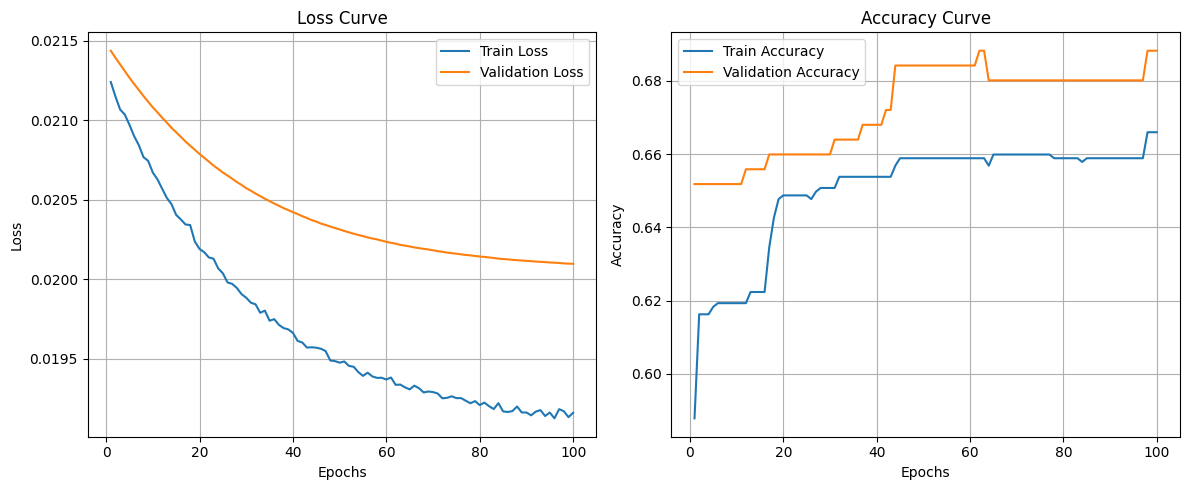

In [66]:
epochs_range = list(range(1, epochs + 1))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss
axs[0].plot(epochs_range, train_losses, label="Train Loss")
axs[0].plot(epochs_range, val_losses, label="Validation Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss Curve")
axs[0].legend()
axs[0].grid(True)

# Plot Accuracy
axs[1].plot(epochs_range, train_accuracies, label="Train Accuracy")
axs[1].plot(epochs_range, val_accuracies, label="Validation Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Accuracy Curve")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


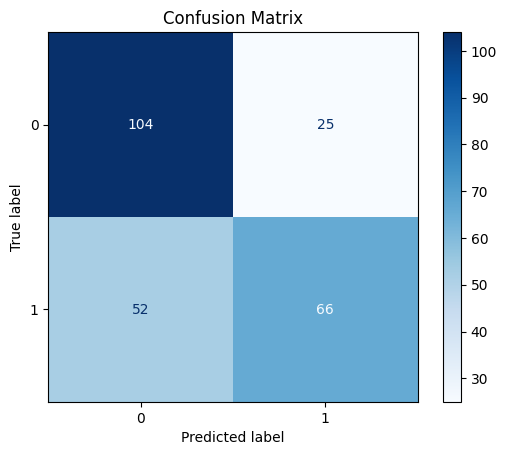

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test_tensor)

y_true = y_test_tensor.cpu().numpy()
y_pred = y_pred.cpu().numpy()

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
